# Introduction

TODO:
- Frame the business problem (why we care) and 3-5 potential use cases for this technology in the retail sector
- Define success in terms of 1-2 specific metrics (recommend using MAPE and RMSE)
- Provide a high-level overview of your approach
- Write a high-level overview of your data
    - Where it came from
    - How it was collected
    - Potential biases it may have
- When you're all finished, write a 1-paragraph executive summary for this engagement

# Import

TODO:
- Load pkl into a dask dataframe for parallelized processing
- Print .head() and .summary()

OPTIONAL:
- Distributively process your code using dask. See here: https://docs.dask.org/en/latest/setup/cloud.html

In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from datetime import timedelta

import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

import shap

from sklearn import metrics
import sklearn
import math

# Import UDFs
import sys
sys.path.append('./src')
from utilities import *
from exploration import *
from feature_engineering import *
from modeling import *


In [7]:
pandas_df = pd.read_pickle("raw_weekly_df.pkl")
dask_df = dd.from_pandas(pandas_df, npartitions=8)

In [9]:
(pandas_df.info(memory_usage="Deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   dept_id   category      
 1   cat_id    category      
 2   item_id   category      
 3   state_id  category      
 4   store_id  category      
 5   datetime  datetime64[ns]
 6   sales     float32       
dtypes: category(5), datetime64[ns](1), float32(1)
memory usage: 117.5 MB


In [11]:
#Unable to allocate 365. MiB for an array with shape (7, 6841121) and data type float64 error?
downcast(pandas_df, '%Y-%m-%d')

,dept_id,cat_id,item_id,state_id,store_id,datetime,sales
0,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2011-01-31,3.0
1,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2011-02-07,9.0
2,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2011-02-14,9.0
3,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2011-02-21,8.0
4,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2011-02-28,14.0
...,...,...,...,...,...,...,...
6841116,HOUSEHOLD_2,HOUSEHOLD,HOUSEHOLD_2_516,WI,WI_3,2016-05-23,0.0
6841117,HOUSEHOLD_2,HOUSEHOLD,HOUSEHOLD_2_516,WI,WI_3,2016-05-30,0.0
6841118,HOUSEHOLD_2,HOUSEHOLD,HOUSEHOLD_2_516,WI,WI_3,2016-06-06,0.0
6841119,HOUSEHOLD_2,HOUSEHOLD,HOUSEHOLD_2_516,WI,WI_3,2016-06-13,0.0


# Data Exploration & Transformation

TODO:
- Check for outliers and missing data
- Check for duplicates
- Check datatypes and comment on whether they make sense
- Plot univariate / bivariate graphs to better understand your data, especially for your target variable, in seaborn
- Standardize, normalize, or log your target variable
- Split your data into training, testing, and holdout sets and explain why this step is important

In [13]:
pandas_df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
6841116    False
6841117    False
6841118    False
6841119    False
6841120    False
Length: 6841121, dtype: bool

- shows that none of the rows are duplicated

In [14]:
pandas_df.loc[pandas_df.duplicated() != False]

,dept_id,cat_id,item_id,state_id,store_id,datetime,sales


 - 6841121 cells of data are in the data set
 - the mean of the sales from all pieces of data is 9.60301
 - the range of the sales from the data is 0 to 4220
 - the distribution of the data shows 25% of the sales data having a value below 0, 50% of the sales data having a value below 3 (median), and 75% of the sales data having a value below 9
 - the sales data is skewed right since the mean is greater than the median

In [15]:
pandas_df.describe()

,sales
count,6.841121e+06
mean,9.603010e+00
std,2.584863e+01
min,0.000000e+00
25%,0.000000e+00
50%,3.000000e+00
75%,9.000000e+00
max,4.220000e+03


The majority of sales are between 0 and 10, with most sales falling at 0.

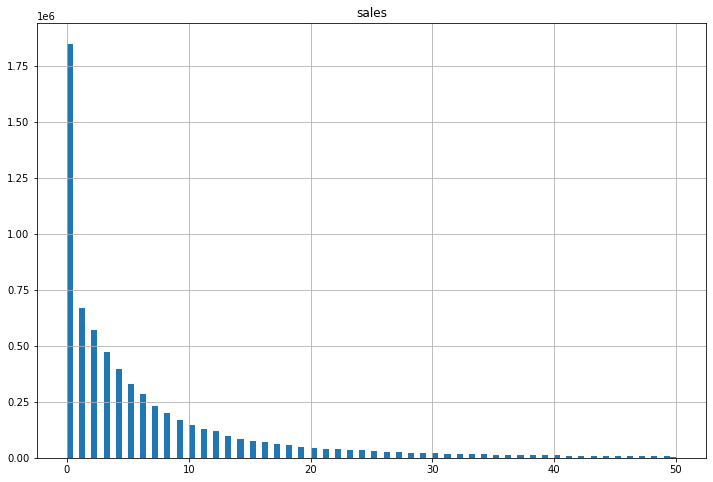

In [17]:
#TODO source files shouldn't call functions; move to .main
univariate_sales_histogram(pandas_df, "sales")

Out of all three states, CA has the most number of sales (around 700,000 sales at 0.0) as compared to Wisconsin and Texas.
This makes sense since California has the largest population compared to the other two.

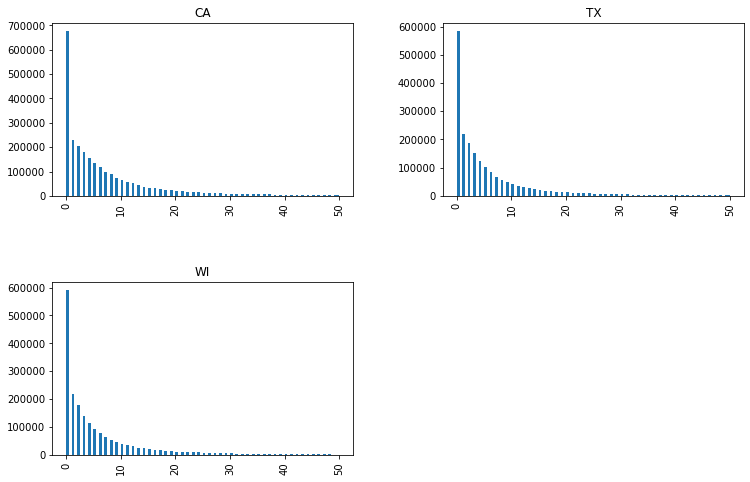

In [18]:
bivariate_sales_by_state(pandas_df, "sales")


In the previous observation, CA was observed to have the most number of 0.0 sales compared to the other two states. However, through this histogram, we see that CA actually has more stores than Texas and Wisconsin. All the graphs of the stores seem pretty similar, but if you observe closely, CA_1, CA_2, CA_3 (especially CA_3), CA_4, TX_1, TX_2 all have sales between 30 and 50 as well, unlike the other stores. This makes sense as well since CA has the largest population compared to the other two states, and compared to Wisconsin, Texas has a larger population."""

In [ ]:
bivariate_sales_by_store(pandas_df, "sales")

In [ ]:
#TODO split these up into markdown cells (see examples above)
sales_boxplot(pandas_df, "sales")
"""The max sales value, 4220 is clearly an outlier. There also seem to be 6 other outliers since they are separate. All the outliers are larger not smaller."""
"""California has this outlier which is the largest value; this makes sense since California has a larger amount of people who contribute to these larger outliers occassionally."""
sales_box_plot_by_state_id(pandas_df, "sales")
"""California has the largest value, 4220, which is also its largest outlier. California has 2 outliers that are 
at least 1000 more than the maximum in its data. Texas and Wisconsin have outliers that are smaller than 2000. Wisconsin has the least number of outliers."""
sales_box_plot_by_store_id(pandas_df, "sales")
"""Every store's outliers are beneath 2000 except for CA_3, all of whose outliers crossed 2000.
Since the range for CA_3 is higher than that of every other store, it indicates that CA_3 had the most sales."""
"""This makes sense since California has the largest population, so there will be more sales and larger outliers."""



In [ ]:
heatmap_to_see_missing_data(pandas_df)
"""The heatmap has a display column for each series in a pandadataframe, and will have horizontal rows within each column wherever there are missing values/data (NaN). In this case, there aren't any missing data so the heatmap is empty."""

# Feature Engineering

TODO:
- Discretize any categorical features
- Develop 3+ new time-related features and 3+ new product-related features as functions in a script called 'feature_engineering.py' in ./src
    - Time-related features: MonthYear, holiday flags, etc.
    - Product-related features: average number of items sold per month in each store (frequency), last time product sold in the store (recency), etc. 

In [3]:
standardize(pandas_df,'sales')


0         -0.259046
1         -0.020909
2         -0.020909
3         -0.060599
4          0.177539
             ...   
6841116   -0.378115
6841117   -0.378115
6841118   -0.378115
6841119   -0.378115
6841120   -0.378115
Name: sales, Length: 6841121, dtype: float32

In [4]:
unstandardize(standardize(pandas_df,'sales'),'sales')

0           3.0
1           9.0
2           9.0
3           8.0
4          14.0
           ... 
6841116     0.0
6841117     0.0
6841118     0.0
6841119     0.0
6841120     0.0
Name: sales, Length: 6841121, dtype: float32

In [6]:
stat_feature(pandas_df,'state_id','sales',['mean','min','max'])

,mean,min,max
state_id,,,
CA,10.585984,0.0,4220.000488
TX,9.033415,0.0,1871.000122
WI,8.882002,0.0,1755.000122


In [11]:
cum_stat(pandas_df,'state_id','sales')


6841121


In [8]:
detrend_feature(pandas_df,'state_id','sales')

0          NaN
1          6.0
2          0.0
3         -1.0
4          6.0
          ... 
6841116    0.0
6841117    0.0
6841118    0.0
6841119    0.0
6841120    0.0
Name: sales, Length: 6841121, dtype: float32

# Modeling

TODO: 
- Write a function to run your lightgbm and xgboost models on your training data and output your in-sample and out-of-sample error RMSE and MAPE
- Use your function to 'tune' both algorithms by passing in different combinations of hyperparameters (max depth, subsampling, etc.) to optimize for OOS RMSE
- Plot your OOS RMSE on the y-axis and your various hyperparameter combinations on the x-axis to select the best combination
- Retrain your models on your train + test data and measure your IS and OOS error metrics on your holdout data 

OPTIONAL:
- Validate that your results are accurate using k-fold cross-validation. Note that this step is extremely important, but can be time-intensive; including it here as optional to be conscious of our time constraints.

In [19]:
#print(pandas_df.filter(items=['dept_id', 'cat_id','item_id','state_id','store_id']))
pandas_df = pd.concat([pandas_df.filter(items=['dept_id', 'cat_id','item_id','state_id','store_id']),standardize(pandas_df,'sales')], axis=1)
train_set, test_set= np.split(pandas_df, [int(.67 *len(pandas_df))])
print(pandas_df)

             dept_id     cat_id          item_id state_id store_id     sales
0            FOODS_1      FOODS      FOODS_1_001       CA     CA_1 -0.255449
1            FOODS_1      FOODS      FOODS_1_001       CA     CA_1 -0.023329
2            FOODS_1      FOODS      FOODS_1_001       CA     CA_1 -0.023329
3            FOODS_1      FOODS      FOODS_1_001       CA     CA_1 -0.062015
4            FOODS_1      FOODS      FOODS_1_001       CA     CA_1  0.170105
...              ...        ...              ...      ...      ...       ...
6841116  HOUSEHOLD_2  HOUSEHOLD  HOUSEHOLD_2_516       WI     WI_3 -0.371510
6841117  HOUSEHOLD_2  HOUSEHOLD  HOUSEHOLD_2_516       WI     WI_3 -0.371510
6841118  HOUSEHOLD_2  HOUSEHOLD  HOUSEHOLD_2_516       WI     WI_3 -0.371510
6841119  HOUSEHOLD_2  HOUSEHOLD  HOUSEHOLD_2_516       WI     WI_3 -0.371510
6841120  HOUSEHOLD_2  HOUSEHOLD  HOUSEHOLD_2_516       WI     WI_3 -0.371510

[6841121 rows x 6 columns]


In [20]:

param = {'n_estimators':1000,
        'learning_rate':0.3,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'max_depth':8,
        'num_leaves':50,
        'min_child_weight':300}
X_train = train_set.filter(items=['dept_id', 'cat_id','item_id','state_id','store_id'])
Y_train = train_set.filter(items=['sales'])

In [28]:
train_lgbm({},X_train,Y_train)

'modeling'

In [ ]:
X_test = test_set.filter(items=['dept_id', 'cat_id','item_id','state_id','store_id'])
M = lgbm_predict(X_test)

In [ ]:
Y_test = test_set.filter(items=['sales'])
Y_test = Y_test.iloc[:,0].array
print(Y_test)
print(M)

In [27]:
lgbm_plot(Y_test, M)

NameError: name 'Y_test' is not defined

In [26]:
calc_mape(Y_test,M)

NameError: name 'Y_test' is not defined

# Interpretation

TODO:
- Create a SHAP plot for our best model and interpret its results
